In [201]:
import glob
import scipy
import os,sys
import zipfile
import numpy as np
import nibabel as nib
import tensorflow as tf
from scipy import ndimage
from tensorflow import keras
from natsort import natsorted
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from aifnet_utils.preprocess import read_nifti_file, normalize, normalize_aif, process_scan, normalize_zero_one
from aifnet_utils.data_loaders import ISLES18DataGen_aif, read_isles_volumepaths_from_file_otf, read_isles_annotations_from_file, ISLES18DataGen_aifvof_otf
from aifnet_utils.data_loaders import delay_sequence_padding, anticipate_sequence_padding, late_bolus, early_bolus
from aifnet_utils.results import plot_predictions
from aifnet_utils.losses import MaxCorrelation
from scipy import signal
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from scipy.linalg import convolution_matrix, toeplitz, circulant
from sklearn.linear_model import Ridge
from matplotlib import pyplot, image, transforms
from scipy import ndimage
from numpy import inf
import matplotlib.patches as patches
import random
keras.backend.set_image_data_format('channels_last')

%matplotlib inline
!pwd

/home/sebastian/experiments/aifnet_replication


In [2]:
#Reading an example PCT volume
LOCATION = 'INSEL'
if LOCATION == 'LOCAL':
    ROOT_EXP = '/Users/sebastianotalora/work/postdoc/ctp/aifnet_replication/'
    root_dir  = '/Users/sebastianotalora/work/postdoc/data/ISLES/'

if LOCATION == 'INSEL':
    ROOT_EXP = '/home/sebastian/experiments/aifnet_replication/'
    root_dir  = '/media/sebastian/data/ASAP/ISLES2018_Training'

if LOCATION == 'SERVER':
    ROOT_EXP = '/home/sotalora/aifnet_replication/'
    root_dir     = '/data/images/sotalora/ISLES18/'

aif_annotations_path = ROOT_EXP + 'radiologist_annotations.csv'


In [3]:
min_num_volumes_ctp = 43
current_fold = 1
#Reading AIFs and VOFs for each of the partitions
train_partition_path = ROOT_EXP+'/partitions_cleaned/fold_'+str(current_fold) +'/train_v2.txt'
valid_partition_path = ROOT_EXP+'/partitions_cleaned/fold_'+str(current_fold) +'/valid_v2.txt'
test_partition_path =  ROOT_EXP+'/partitions_cleaned/fold_'+str(current_fold) +'/test_v2.txt'

aif_annotations_train, vof_annotations_train = read_isles_annotations_from_file(aif_annotations_path, train_partition_path, 
                                                root_dir, min_num_volumes_ctp, return_aif_only = False)
aif_annotations_valid, vof_annotations_valid = read_isles_annotations_from_file(aif_annotations_path, valid_partition_path, root_dir, 
                                        min_num_volumes_ctp, return_aif_only = False)
aif_annotations_test, vof_annotations_test = read_isles_annotations_from_file(aif_annotations_path,  test_partition_path,
                                        root_dir, min_num_volumes_ctp, return_aif_only = False)

ctp_volumes_train = read_isles_volumepaths_from_file_otf(root_dir, train_partition_path, aif_annotations_path)
ctp_volumes_valid = read_isles_volumepaths_from_file_otf(root_dir, valid_partition_path, aif_annotations_path)
ctp_volumes_test = read_isles_volumepaths_from_file_otf(root_dir, test_partition_path, aif_annotations_path)

print(len(ctp_volumes_train), len(aif_annotations_train))
print(len(ctp_volumes_valid), len(aif_annotations_valid))
print(len(ctp_volumes_test), len(aif_annotations_test))



107 107
13 13
31 31


In [4]:
train_datagen = ISLES18DataGen_aifvof_otf(ctp_volumes=ctp_volumes_train, annotations_aif=aif_annotations_train,
                            annotations_vof = vof_annotations_train,
                            minimum_number_volumes_ctp = min_num_volumes_ctp, batch_size=1,
                                        time_arrival_augmentation = True)
validation_datagen =  ISLES18DataGen_aifvof_otf(ctp_volumes=ctp_volumes_valid, annotations_aif=aif_annotations_valid,
                            annotations_vof = vof_annotations_valid,
                            minimum_number_volumes_ctp = min_num_volumes_ctp, batch_size=1,
                                        time_arrival_augmentation = True)


In [5]:
example_id = 1
sample_pct = train_datagen.__getitem__(example_id)
pct_vals = sample_pct[0][0,:,:,:,:]

aif = sample_pct[1][0].T
vof = sample_pct[1][1].T

In [6]:
path_case = '/'.join(train_datagen.ctp_volumes[example_id]['image'].split('/')[0:-2])
path_cbf = glob.glob(path_case+"/*CBF*/*nii")[0]
path_cbf

'/media/sebastian/data/ASAP/ISLES2018_Training/TESTING/case_4/SMIR.Brain.XX.O.CT_CBF.346319/SMIR.Brain.XX.O.CT_CBF.346319.nii'

Text(0, 0.5, 'Normalized Density (HU)')

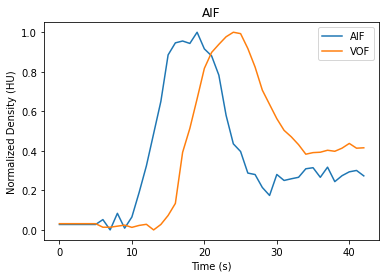

In [7]:
plt.title('AIF')        
#y = normalize_zero_one(aif)
#y_p = normalize_zero_one(vof)
#plt.plot(mu_voi)
#plt.plot(y_p)
plt.plot(aif)
plt.plot(vof)
plt.legend([ 'AIF','VOF'])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Density (HU)')


In [8]:
A = np.multiply(np.tril(np.ones((aif.shape[0],aif.shape[0]))), circulant(aif))

In [9]:
A

array([[0.02751456, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02751456, 0.02751456, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02751456, 0.02751456, 0.02751456, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.29382855, 0.2743054 , 0.24431697, ..., 0.02751456, 0.        ,
        0.        ],
       [0.30078984, 0.29382855, 0.2743054 , ..., 0.02751456, 0.02751456,
        0.        ],
       [0.27334811, 0.30078984, 0.29382855, ..., 0.02751456, 0.02751456,
        0.02751456]])

In [10]:
np.flip(A,axis=0)[0:-1,:-1].shape

(42, 42)

In [11]:
aif

array([0.02751456, 0.02751456, 0.02751456, 0.02751456, 0.02751456,
       0.02751456, 0.05221477, 0.        , 0.0838844 , 0.00880275,
       0.06537983, 0.18953613, 0.32379969, 0.48700206, 0.65032227,
       0.88544987, 0.9462975 , 0.95561351, 0.94337853, 1.        ,
       0.91583685, 0.88035854, 0.78291575, 0.57959659, 0.43542482,
       0.39660934, 0.28755633, 0.28019038, 0.21472979, 0.17427909,
       0.28046334, 0.25018167, 0.25868609, 0.26621924, 0.30929104,
       0.31468923, 0.26614574, 0.31746932, 0.24431697, 0.2743054 ,
       0.29382855, 0.30078984, 0.27334811])

In [12]:
A[0:5,0:5].squeeze()

array([[0.02751456, 0.        , 0.        , 0.        , 0.        ],
       [0.02751456, 0.02751456, 0.        , 0.        , 0.        ],
       [0.02751456, 0.02751456, 0.02751456, 0.        , 0.        ],
       [0.02751456, 0.02751456, 0.02751456, 0.02751456, 0.        ],
       [0.02751456, 0.02751456, 0.02751456, 0.02751456, 0.02751456]])

In [13]:
aa = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(aa)
np.flip(aa,axis=0)[0:-1,0:-1]

[[1 2 3]
 [4 5 6]
 [7 8 9]]


array([[7, 8],
       [4, 5]])

In [15]:
def build_circular_matrix(A):
    A_circular = np.zeros((A.shape[0]*2,A.shape[1]*2))
    A_circular[0:A.shape[0], 0:A.shape[1]] = A # First Cuadrant
    A_circular[0:A.shape[0]-1,A.shape[0]+1:] = np.flip(np.flip(A,axis=0)[0:-1,:-1].T,axis=0).T # Second Cuadrant
    A_circular[A.shape[0]:,0:A.shape[1]-1] = np.flip(np.flip(A,axis=1)[0:-1,:].T,axis=0) # Third Cuadrant
    A_circular[A.shape[0]:,A.shape[0]:] = A # Fourth Cuadrant
    np.savetxt('A_circular.csv',delimiter=',',X=A_circular)
    return A_circular

In [16]:
circular_aa = build_circular_matrix(aa)
circular_aa

array([[1., 2., 3., 0., 8., 7.],
       [4., 5., 6., 0., 5., 4.],
       [7., 8., 9., 0., 0., 0.],
       [1., 4., 0., 1., 2., 3.],
       [2., 5., 0., 4., 5., 6.],
       [3., 6., 0., 7., 8., 9.]])

In [17]:
def build_circular_matrix_implicit(aif, m=2):
    A_circular = np.zeros((aif.shape[0],aif.shape[0]))
    for i in range(A_circular.shape[0]-1):
        for j in range(A_circular.shape[1]-1):
            if j<=i:
                A_circular[i,j] = aif[i-j+1]
            if j>i:
                #print(i,j)
                A_circular[i,j] = aif[m+i-j+1]
    np.savetxt('A_circular.csv',delimiter=',',X=A_circular)
    return A_circular

In [18]:
aif_ext = np.concatenate((aif,np.zeros(aif.shape[0])), axis = 0)
aif_ext


array([0.02751456, 0.02751456, 0.02751456, 0.02751456, 0.02751456,
       0.02751456, 0.05221477, 0.        , 0.0838844 , 0.00880275,
       0.06537983, 0.18953613, 0.32379969, 0.48700206, 0.65032227,
       0.88544987, 0.9462975 , 0.95561351, 0.94337853, 1.        ,
       0.91583685, 0.88035854, 0.78291575, 0.57959659, 0.43542482,
       0.39660934, 0.28755633, 0.28019038, 0.21472979, 0.17427909,
       0.28046334, 0.25018167, 0.25868609, 0.26621924, 0.30929104,
       0.31468923, 0.26614574, 0.31746932, 0.24431697, 0.2743054 ,
       0.29382855, 0.30078984, 0.27334811, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [20]:
def compute_pseudoinverse(A):
    return scipy.linalg.pinv2(A)

In [21]:
def svd_truncated(A,truncation_vals=3):
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    S = np.diag(1/s)
    S[-truncation_vals:,-truncation_vals:] = 0
    return u,S,vh

In [22]:
def perform_deconvolution(perf_data,pseudo_inverse):
    residues = np.zeros((perf_data.shape)) #WxHxSlicesxTime
    CBFs = np.zeros((perf_data.shape[0],perf_data.shape[1],perf_data.shape[2]))
    for cur_slice in range(perf_data.shape[2]):
        for i in range(perf_data.shape[0]):
            for j in range (perf_data.shape[1]):
                voi = perf_data[i,j,cur_slice,:]
                residue_f = np.matmul(pseudo_inverse,voi.T)
                CBFs[i,j,cur_slice] = np.max(residue_f)
                residues[i,j,cur_slice,:] = residue_f
    return CBFs, residues

In [23]:
def perform_deconvolution_circular(perf_data,pseudo_inverse):
    residues = np.zeros((perf_data.shape)) #WxHxSlicesxTime
    CBFs = np.zeros((perf_data.shape[0],perf_data.shape[1],perf_data.shape[2]))
    for cur_slice in range(perf_data.shape[2]):
        for i in range(perf_data.shape[0]):
            for j in range (perf_data.shape[1]):
                voi = np.concatenate((perf_data[i,j,cur_slice,:],np.zeros(perf_data[i,j,cur_slice,:].shape[0])), axis = 0)   
                #print(voi.shape)
                residue_f = np.matmul(pseudo_inverse,voi.T)
                CBFs[i,j,cur_slice] = np.max(residue_f)
                residues[i,j,cur_slice,:] = residue_f[0:43]
    return CBFs, residues

In [24]:
def plot_cbf_map(train_datagen, selected_slice,example_id,contrast_threshold):
    #Gettring Ground truth CBF
    path_case = '/'.join(train_datagen.ctp_volumes[example_id]['image'].split('/')[0:-2])
    path_cbf = glob.glob(path_case+"/*CBF*/*nii")[0]
    gt_cbf = nib.load(path_cbf).get_fdata()
    gt_cbf[gt_cbf >contrast_threshold] = 0
    gt_img = np.array(normalize_zero_one(gt_cbf[:,:,selected_slice])*255,dtype = 'uint8')
    gt_img = ndimage.rotate(gt_img, 90)
    gt_img = np.flip(gt_img,axis=1)
    plt.imshow(gt_img,cmap=plt.cm.jet)
    return gt_cbf

In [25]:
def plot_tmax_map(train_datagen, selected_slice,example_id):
    #Gettring Ground truth Tmax
    path_case = '/'.join(train_datagen.ctp_volumes[example_id]['image'].split('/')[0:-2])
    path_tmax = glob.glob(path_case+"/*Tmax*/*nii")[0]
    healty_tmax = nib.load(path_tmax).get_fdata()
    #print(healty_tmax.shape)

    healty_tmax[healty_tmax > 6] = 0

    print(np.max(healty_tmax))
    gt_healty = np.array(normalize_zero_one(healty_tmax[:,:,selected_slice])*255,dtype = 'uint8')
    gt_healty = ndimage.rotate(gt_healty, 90)
    gt_healty = np.flip(gt_healty,axis=1)
    plt.imshow(gt_healty,cmap=plt.cm.jet)
    return gt_healty

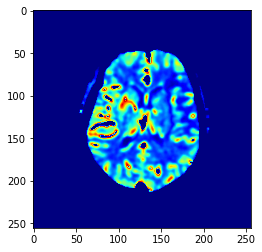

In [26]:
selected_slice = 0
gt_cbf = plot_cbf_map(train_datagen, selected_slice,example_id,contrast_threshold=600)

In [27]:
np.max(gt_cbf)

600.0

6.0


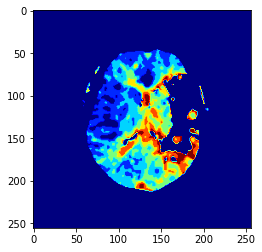

In [28]:
gt_healty = plot_tmax_map(train_datagen, selected_slice,example_id)

In [266]:
def plot_estimatedCBF_map(gt_cbf, CBF, gt_healty, selected_slice,normalize_healthy_tissue):
    #Gettring Ground truth Tmax
    mask_zeros = gt_cbf[:,:,selected_slice] != 0
    mask_zeros = np.array(mask_zeros,dtype='int')
    mask_zeros.shape
    img = CBF[:,:,selected_slice]
    img = np.multiply(img,mask_zeros)

    img[img > np.max(img)] = 0
    print(np.max(img))
    #img[img >contrast_threshold] = 0

    #estimated_cbf = np.array(normalize_zero_one(img)*255,dtype = 'uint8')
    #estimated_cbf = np.array(normalize_zero_one(img)*255,dtype = 'uint8')

    #estimated_cbf = ndimage.rotate(estimated_cbf, 90)
    estimated_cbf = ndimage.rotate(img, 90)
    estimated_cbf = np.flip(estimated_cbf,axis=1)
    if normalize_healthy_tissue:
        mask_healthy = gt_healty>0
        mask_healthy.shape
        mean_cbf_healthy = np.mean(estimated_cbf[mask_healthy])
        #print(mean_cbf_healthy)
        estimated_cbf = np.multiply(1/(mean_cbf_healthy), estimated_cbf)
    plt.imshow(estimated_cbf,cmap=plt.cm.jet)    
    return estimated_cbf

In [30]:
#Two ways of computing the psuedoinverse of A: 1) using a truncated SVD or using
def aif_inverse(A,number_of_truncated_values=8,epsilon=0.01):
    #number_of_truncated_values = 8
    u,S,vh = svd_truncated(A,truncation_vals=number_of_truncated_values)
    #epsilon = 0.01#0.001 is ok for most cases
    max_S = np.max(np.diag(S))
    S[S<epsilon*max_S] = 0

    A_inv = np.matmul(np.matmul(u,S), vh)

    pseudo_inv = compute_pseudoinverse(A)

    invD = np.matmul(vh,compute_pseudoinverse(S))
    invD = np.matmul(invD,u.T)
    return invD, S

In [31]:
A.shape

(43, 43)

In [327]:
truncated_eigenvals = 10

In [328]:
truncated_eigenvals = 10
circularA = build_circular_matrix_implicit(aif_ext)
inverse_aif_circular, S_circ = aif_inverse(circularA,number_of_truncated_values=truncated_eigenvals,epsilon=0.001)
CBFs_circular, residue_functions_circular = perform_deconvolution_circular(pct_vals,inverse_aif_circular)

In [329]:
inverse_aif, S = aif_inverse(A,number_of_truncated_values=truncated_eigenvals,epsilon=0.001)
CBFs, residue_functions = perform_deconvolution(pct_vals,inverse_aif)

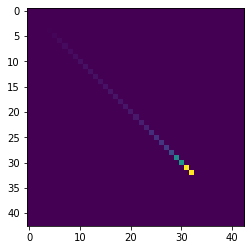

In [330]:
plt.imshow(S)

In [304]:
np.diag(S)

array([ 0.        ,  0.15040371,  0.20397369,  0.32237869,  0.60154883,
        1.29126357,  2.23774144,  2.60760404,  2.61044723,  2.95357915,
        3.90288196,  3.9670272 ,  4.15254091,  4.18032545,  4.21400946,
        4.30077627,  4.84510497,  4.86567233,  5.06451126,  5.61818356,
        5.7196672 ,  6.39178885,  7.82616029,  7.96519107, 12.03378981,
       12.80676201, 13.63043417, 15.60369979, 21.42001668, 43.20204162,
       48.42082365, 90.64859008, 91.3262302 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

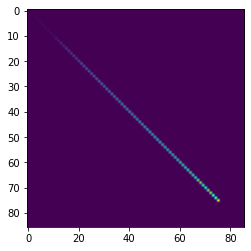

In [305]:
plt.imshow(S_circ)

In [306]:
#CBFs, residue_functions = perform_deconvolution(pct_vals,invD)

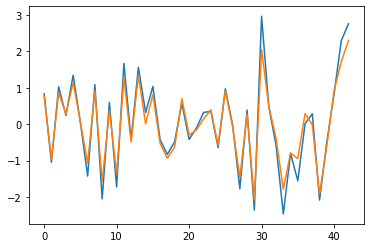

In [307]:
location_residue_1 = (170,130)
location_residue_2 = (90,150)
plt.plot(residue_functions_circular[location_residue_1[0],location_residue_1[1],selected_slice,:])
plt.plot(residue_functions_circular[location_residue_2[0],location_residue_2[1],selected_slice,:])


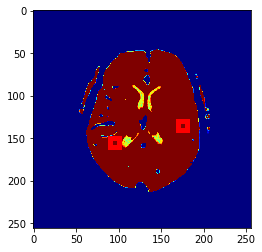

In [331]:
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(estimated_cbf,cmap=plt.cm.jet, vmax=1)

# Create a Rectangle patch
rect1 = patches.Rectangle((location_residue_1[0], location_residue_1[1]), 10, 10, linewidth=5, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((location_residue_2[0], location_residue_2[1]), 10, 10, linewidth=5, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)

plt.show()

2.411216601311339


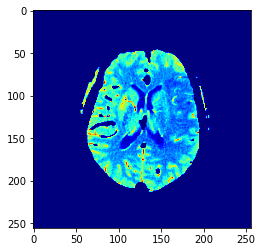

In [333]:
estimated_cbf = plot_estimatedCBF_map(gt_cbf, CBFs, gt_healty, selected_slice,normalize_healthy_tissue=True)
plt.imshow(estimated_cbf,cmap=plt.cm.jet, vmax=2.9)

10.520292614770394


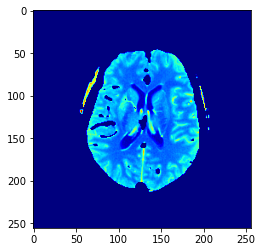

In [340]:
truncated_eigenvals = 80
circularA = build_circular_matrix_implicit(aif_ext)
inverse_aif_circular, S_circ = aif_inverse(circularA,number_of_truncated_values=truncated_eigenvals,epsilon=0.001)
CBFs_circular, residue_functions_circular = perform_deconvolution_circular(pct_vals,inverse_aif_circular)

estimated_cbf = plot_estimatedCBF_map(gt_cbf, CBFs_circular, gt_healty, selected_slice,normalize_healthy_tissue=False)
plt.imshow(estimated_cbf,cmap=plt.cm.jet, vmax=10)